# Real Time Intelligent Systems
## Final Project - Models/Strategies
### Roselyn R., Aashai A., Alberto B., Jaelynn K.

Creating a financial stock trading system that helps inform decisions for those that invest in stocks through a three-prong approach: real-time forecasting, event-driven trading simulation, and risk management.

>[Packages](#scrollTo=kJSM7vpKUc2d)

>[Alpaca API Setup](#scrollTo=zkDLmMPiUZXq)

>[Alpaca Account Information](#scrollTo=vB89ikoTYpXs)

>[Historical Data](#scrollTo=RLyBGJpcZE0H)

>[Data for Strategies](#scrollTo=bGmqPkIzii_B)

>[Strategy 1: Real Time Forecasting](#scrollTo=TGFhvs9yhEyS)

>>[ARIMA](#scrollTo=GT5NKqI0fWbv)

>>[RNN](#scrollTo=nvAK33ZqkB34)

>>[Ensemble Model: ARIMA + RNN](#scrollTo=Ae6dKN3YQQiP)

>[Strategy 2: Event-Driven Trading Simulation](#scrollTo=nUU97-7svKnK)

>[Strategy 3: Risk Management](#scrollTo=OdHsI1u-vrMz)

>>[Measure Stock Tendencies to Reach a “Volatile Behavior” 30 Days after the Inference Point to Determine Risk of Each Stock](#scrollTo=X98l0Rk5ZLBy)

>>[Value at Risk for Each Symbol](#scrollTo=C-bWYo-nYpBP)

>[Chosen Model and Stock](#scrollTo=6dlj-Mz5GRx6)

>>[Save Model](#scrollTo=JmrDFnY0KZmt)

>[Backtesting](#scrollTo=upVbrwVZpjWh)

>[References](#scrollTo=TeBB9yoSHBni)



## **Packages**

In [1]:
# Alpaca
!pip install alpaca-py
!pip install alpaca-trade-api

# Sentiment Analysis
!pip install transformers

# ARIMA Helper
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.9/111.9 kB 773.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.8
    Uninstalling msgpack-1.0.8:
      Successfully uninstalled msgpack-1.0.8
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websockets-12.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Alpaca
import requests
import json
import alpaca_trade_api as tradeapi
from alpaca_trade_api import REST, Stream
from alpaca.data.timeframe import TimeFrame
from alpaca.data.requests import StockBarsRequest
from alpaca.data.historical import StockHistoricalDataClient

# Strategies
import time
import random
import os
from math import sqrt
import tensorflow as tf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve
from transformers import pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers

# Google
from google.colab import userdata
from google.colab import drive

# Warnings
import warnings
warnings.filterwarnings('ignore')

## **Alpaca API Setup**

In [4]:
API_KEY = userdata.get('API_KEY')
SECRET_KEY = userdata.get('SECRET_KEY')

In [5]:
BASE_URL = "https://paper-api.alpaca.markets"
HISTORICAL_URL = 'https://data.alpaca.markets/v2/stocks/{symbol}/bars'
NEWS_URL = 'https://data.alpaca.markets/v1beta1/news'
ACCOUNT_URL = "{}/v2/account".format(BASE_URL)
ORDERS_URL = "{}/v2/orders".format(BASE_URL)
HEADERS = {'APCA-API-KEY-ID': API_KEY, 'APCA-API-SECRET-KEY': SECRET_KEY}

## **Alpaca Account Information**

In [6]:
def get_account():
    response = requests.get(ACCOUNT_URL, headers=HEADERS)
    return json.loads(response.content)

In [7]:
if __name__ == "__main__":
    account_info = get_account()
    initial_capital = float(account_info['portfolio_value'])
    print("Initial Capital:", initial_capital)

Initial Capital: 100000.0


# **Historical Data**

In [8]:
client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

request_params = StockBarsRequest(
                        symbol_or_symbols=["AAPL", "GOOGL", "MSFT"],
                        timeframe=TimeFrame.Day,
                        start="2022-01-01 00:00:00",
                        end="2023-12-31 00:00:00"
                 )

bars = client.get_stock_bars(request_params)
bars_df = bars.df
print(bars_df)

                                    open     high       low   close  \
symbol timestamp                                                      
AAPL   2022-01-03 05:00:00+00:00  177.83  182.880  177.7100  182.01   
       2022-01-04 05:00:00+00:00  182.64  182.940  179.1200  179.70   
       2022-01-05 05:00:00+00:00  179.61  180.170  174.6400  174.92   
       2022-01-06 05:00:00+00:00  172.70  175.300  171.6400  172.00   
       2022-01-07 05:00:00+00:00  172.89  174.140  171.0300  172.17   
...                                  ...      ...       ...     ...   
MSFT   2023-12-22 05:00:00+00:00  373.68  375.180  372.7100  374.58   
       2023-12-26 05:00:00+00:00  375.00  376.940  373.5000  374.66   
       2023-12-27 05:00:00+00:00  373.69  375.060  372.8116  374.07   
       2023-12-28 05:00:00+00:00  375.37  376.458  374.1600  375.28   
       2023-12-29 05:00:00+00:00  376.00  377.160  373.4800  376.04   

                                       volume  trade_count        vwap  
sym

# **Data for Strategies**

In [9]:
symbols = ["AAPL", "GOOGL", "MSFT"]

In [10]:
start_date = '2022-01-01'
end_date = '2023-12-31'

In [11]:
data = bars_df

In [12]:
data.isnull().sum()

open           0
high           0
low            0
close          0
volume         0
trade_count    0
vwap           0
dtype: int64

In [13]:
data.head()

open    high     low   close       volume  \
symbol timestamp                                                                
AAPL   2022-01-03 05:00:00+00:00  177.83  182.88  177.71  182.01  112486091.0   
       2022-01-04 05:00:00+00:00  182.64  182.94  179.12  179.70  106090378.0   
       2022-01-05 05:00:00+00:00  179.61  180.17  174.64  174.92   95142198.0   
       2022-01-06 05:00:00+00:00  172.70  175.30  171.64  172.00  103899632.0   
       2022-01-07 05:00:00+00:00  172.89  174.14  171.03  172.17   94554334.0   

                                  trade_count        vwap  
symbol timestamp                                           
AAPL   2022-01-03 05:00:00+00:00     772699.0  181.426035  
       2022-01-04 05:00:00+00:00     831898.0  180.522931  
       2022-01-05 05:00:00+00:00     848518.0  177.303173  
       2022-01-06 05:00:00+00:00     960344.0  173.013218  
       2022-01-07 05:00:00+00:00     715419.0  172.423860

# **Strategy 1: Real Time Forecasting**
Using ARIMA and RNN to Create an Effective Trading Strategy


#### ARIMA

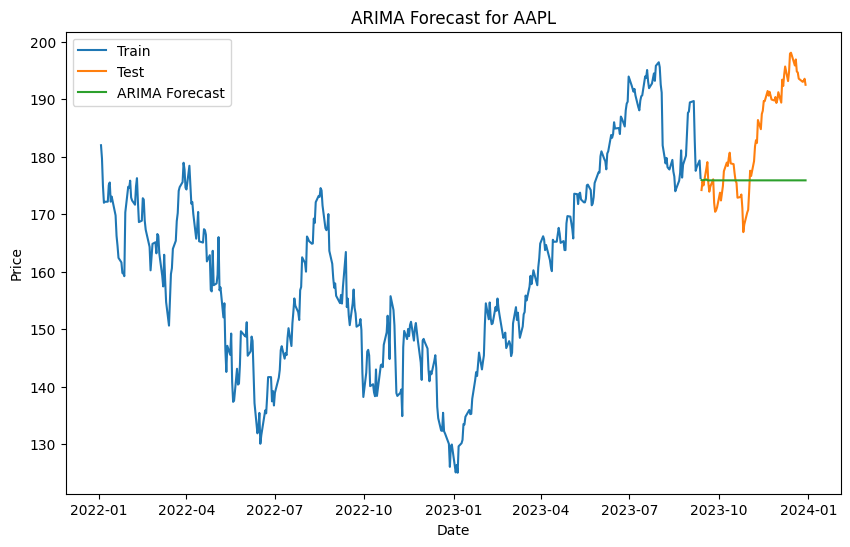


RMSE for ARIMA - Train RMSE for AAPL: 9.32
RMSE for ARIMA - Test RMSE for AAPL: 11.47 





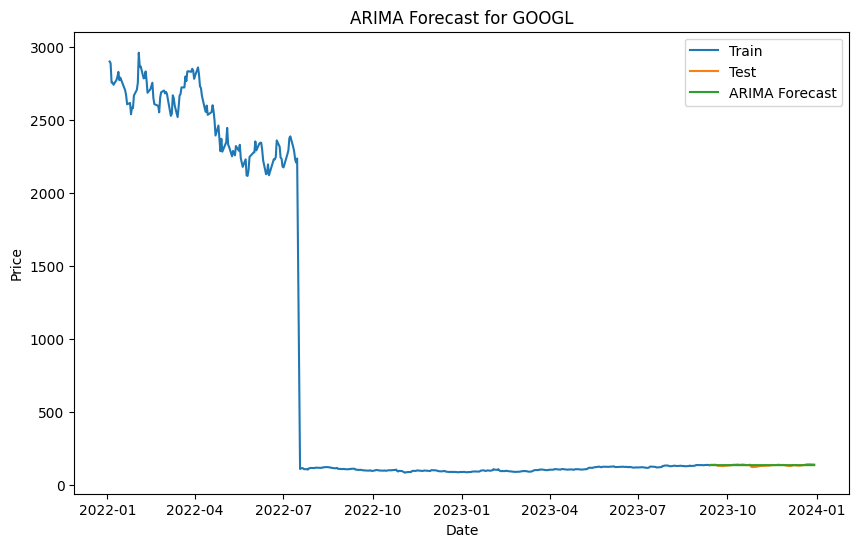


RMSE for ARIMA - Train RMSE for GOOGL: 177.57
RMSE for ARIMA - Test RMSE for GOOGL: 4.67 





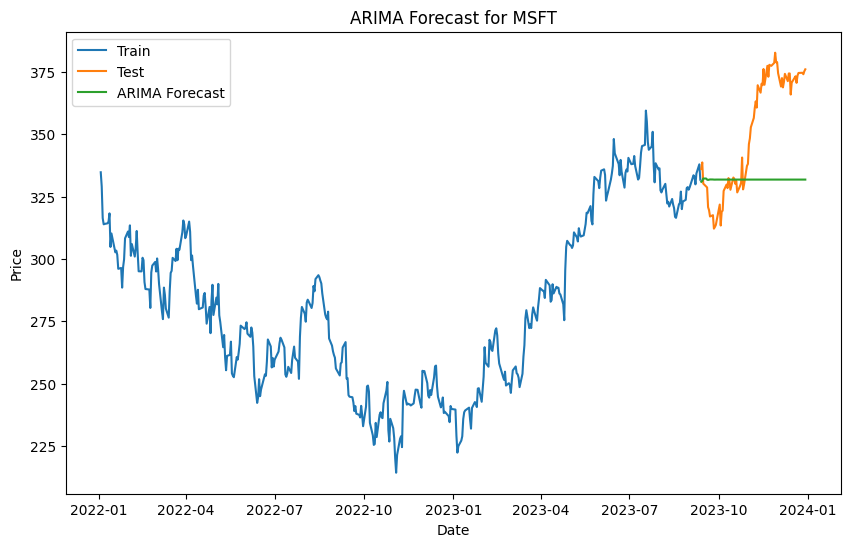


RMSE for ARIMA - Train RMSE for MSFT: 17.13
RMSE for ARIMA - Test RMSE for MSFT: 29.66 





In [ ]:
arima_signals = {}

for symbol in symbols:
    symbol_data = data.loc[symbol]

    # Convert Index to Datetime if Necessary
    if not isinstance(symbol_data.index, pd.DatetimeIndex):
        symbol_data.index = pd.to_datetime(symbol_data.index)

    # Split Data Into Train and Test Datasets
    train_size = int(len(symbol_data) * 0.85)
    train, test = symbol_data[:train_size], symbol_data[train_size:]

    # Fit ARIMA Model
    model_arima = ARIMA(train['close'], order=(5,1,0), freq=train.index.inferred_freq)
    model_fit_arima = model_arima.fit()

    # Predictions
    forecast_arima = model_fit_arima.forecast(steps=len(test))

    # Ensure Index Alignment
    forecast_arima.index = test.index

    # Create Signals: Buy When Forecasted Price Increases, Sell When Forecasted Price Decreases
    signal_arima = np.where(forecast_arima > test['close'], 1, -1)

    # Store Forecasted Values and Signals
    arima_signals[symbol] = {'forecast': forecast_arima, 'signal': signal_arima}

    # Plot Forecast
    plt.figure(figsize=(10,6))
    plt.plot(train.index, train['close'], label='Train')
    plt.plot(test.index, test['close'], label='Test')
    plt.plot(test.index, forecast_arima, label='ARIMA Forecast')
    plt.title('ARIMA Forecast for {}'.format(symbol))
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # RMSE for ARIMA
    rmse_arima_train = sqrt(mean_squared_error(train['close'], model_fit_arima.fittedvalues))
    rmse_arima_test = sqrt(mean_squared_error(test['close'], forecast_arima))
    print('\nRMSE for ARIMA - Train RMSE for {}: {:.2f}'.format(symbol, rmse_arima_train))
    print('RMSE for ARIMA - Test RMSE for {}: {:.2f}'.format(symbol, rmse_arima_test), "\n\n\n")

#### RNN

Epoch 1/20
34/34 [==============================] - 6s 46ms/step - loss: 23384.7949 - val_loss: 31229.9082
Epoch 2/20
34/34 [==============================] - 1s 15ms/step - loss: 18068.9492 - val_loss: 16342.1143
Epoch 3/20
34/34 [==============================] - 1s 18ms/step - loss: 5744.6597 - val_loss: 464.8396
Epoch 4/20
34/34 [==============================] - 1s 17ms/step - loss: 823.2505 - val_loss: 4.2516
Epoch 5/20
34/34 [==============================] - 0s 11ms/step - loss: 652.7176 - val_loss: 19.6475
Epoch 6/20
34/34 [==============================] - 0s 11ms/step - loss: 718.7982 - val_loss: 19.0308
Epoch 7/20
34/34 [==============================] - 0s 12ms/step - loss: 650.5911 - val_loss: 13.6489
Epoch 8/20
34/34 [==============================] - 0s 12ms/step - loss: 513.9290 - val_loss: 72.7404
Epoch 9/20
3/3 [==============================] - 0s 7ms/step

 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

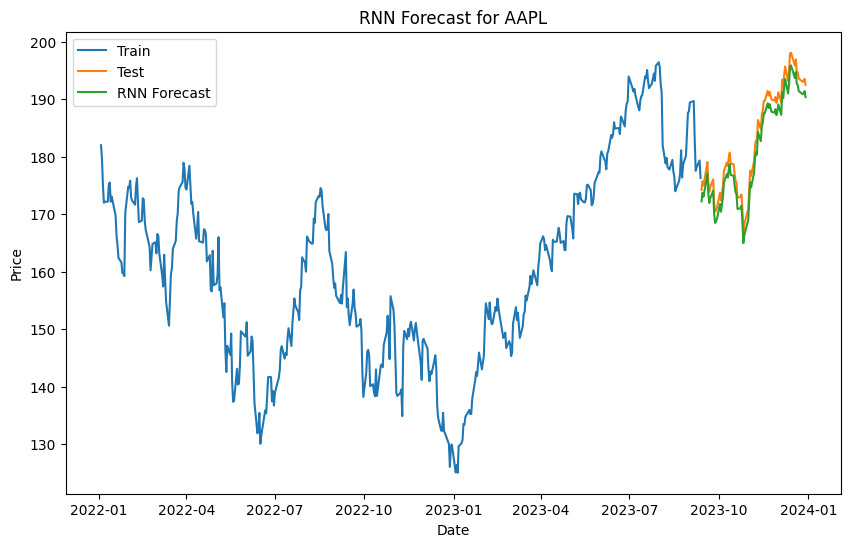



RNN Forecasting - Train RMSE for AAPL: 1.90
RNN Forecasting - Test RMSE for AAPL: 2.06 

Epoch 1/20
34/34 [==============================] - 6s 44ms/step - loss: 2533854.5000 - val_loss: 15824.6689
Epoch 2/20
34/34 [==============================] - 0s 10ms/step - loss: 2516579.5000 - val_loss: 15386.5498
Epoch 3/20
34/34 [==============================] - 0s 9ms/step - loss: 2196450.7500 - val_loss: 11837.6025
Epoch 4/20
34/34 [==============================] - 0s 10ms/step - loss: 1454048.6250 - val_loss: 4678.8047
Epoch 5/20
34/34 [==============================] - 0s 8ms/step - loss: 307832.9062 - val_loss: 135.8505
Epoch 6/20
34/34 [==============================] - 0s 7ms/step - loss: 146613.5469 - val_loss: 491.2546
Epoch 7/20
34/34 [==============================] - 0s 8ms/step - loss: 118556.4219 - val_loss: 380.0349
Epoch 8/20
34/34 [==============================] - 0s 10ms/step - loss: 124366.5547 - val_loss: 305.9337
Epoch 9/20
34/34 [==============================] - 1s

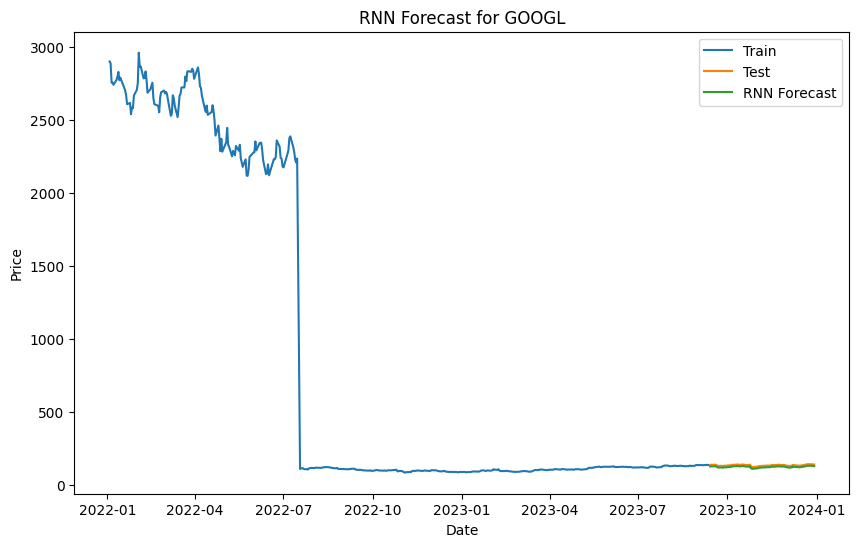



RNN Forecasting - Train RMSE for GOOGL: 30.44
RNN Forecasting - Test RMSE for GOOGL: 10.90 

Epoch 1/20
34/34 [==============================] - 5s 34ms/step - loss: 71861.4609 - val_loss: 101472.5859
Epoch 2/20
34/34 [==============================] - 0s 9ms/step - loss: 61329.9805 - val_loss: 70487.6797
Epoch 3/20
34/34 [==============================] - 0s 12ms/step - loss: 41820.7422 - val_loss: 31627.7109
Epoch 4/20
34/34 [==============================] - 1s 15ms/step - loss: 16062.8350 - val_loss: 4128.7852
Epoch 5/20
34/34 [==============================] - 0s 10ms/step - loss: 5182.7559 - val_loss: 20.1566
Epoch 6/20
34/34 [==============================] - 0s 9ms/step - loss: 4344.3208 - val_loss: 409.2404
Epoch 7/20
34/34 [==============================] - 0s 8ms/step - loss: 4506.8447 - val_loss: 152.7794
Epoch 8/20
34/34 [==============================] - 0s 8ms/step - loss: 4469.2485 - val_loss: 138.2666
Epoch 9/20
34/34 [==============================] - 0s 14ms/step -

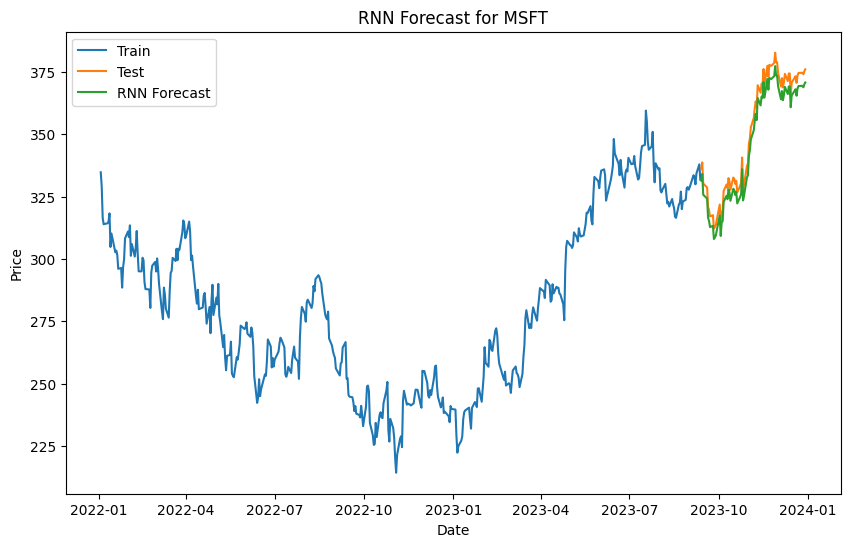



RNN Forecasting - Train RMSE for MSFT: 3.67
RNN Forecasting - Test RMSE for MSFT: 4.84 



In [ ]:
rnn_signals = {}  # Initialize the Dictionary Outside the Loop

for symbol in symbols:

    symbol_data = data.loc[symbol]

    # Convert Index to Datetime if Necessary
    if not isinstance(symbol_data.index, pd.DatetimeIndex):
        symbol_data.index = pd.to_datetime(symbol_data.index)

    # Prepare Data for LSTM
    X = symbol_data['close'].values.reshape(-1, 1)
    y = symbol_data['close'].values

    # Split Data Into Train and Test Datasets
    train_size = int(len(X) * 0.85)
    test_size = len(X) - train_size
    X_train, X_test = X[0:train_size,:], X[train_size:,:]
    y_train, y_test = y[0:train_size], y[train_size:]


    # Reshape Data for LSTM
    X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Define RNN Model
    model_rnn = Sequential([
        LSTM(units=25, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(units=25, activation='relu'),
        Dense(units=1)
    ])

    # Compile Model
    model_rnn.compile(optimizer='adam', loss='mean_squared_error')

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Fit Model
    history = model_rnn.fit(X_train_lstm, y_train, epochs=20, batch_size=10, verbose=1, validation_split=0.2, callbacks=[early_stopping])

    # Predictions
    train_predict_rnn = model_rnn.predict(X_train_lstm)
    test_predict_rnn = model_rnn.predict(X_test_lstm)

    # Create Signals: Buy When Forecasted Price Increases, Sell When Forecasted Price Decreases
    signal_rnn = np.where(test_predict_rnn.squeeze() > X_test_lstm.squeeze(), 1, -1)
    print("\n", signal_rnn, "\n")

    # Store Forecasted Values and Signal
    rnn_signals[symbol] = {'forecast': test_predict_rnn, 'signal': signal_rnn, 'index': symbol_data[train_size:].index}

    # Plot Forecast
    plt.figure(figsize=(10,6))
    plt.plot(symbol_data[:train_size].index, X_train, label='Train')
    plt.plot(symbol_data[train_size:].index, X_test, label='Test')
    plt.plot(symbol_data[train_size:].index, test_predict_rnn, label='RNN Forecast')
    plt.title('RNN Forecast for {}'.format(symbol))
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # RMSE for RNN
    rmse_rnn_train = sqrt(mean_squared_error(y_train, train_predict_rnn))
    rmse_rnn_test = sqrt(mean_squared_error(y_test, test_predict_rnn))
    print("\n")
    print('RNN Forecasting - Train RMSE for {}: {:.2f}'.format(symbol, rmse_rnn_train))
    print('RNN Forecasting - Test RMSE for {}: {:.2f}'.format(symbol, rmse_rnn_test), "\n")

#### Ensemble Model: ARIMA + RNN

In [ ]:
# Combine Predictions
ensemble_rmse_train = []
ensemble_rmse_test = []

# Store RMSE for Ensemble
ensemble_rmse_train.append(rmse_arima_train)
ensemble_rmse_test.append(rmse_arima_test)

ensemble_rmse_train.append(rmse_rnn_train)
ensemble_rmse_test.append(rmse_rnn_test)

# Calculate Ensemble RMSE
ensemble_rmse_train_mean = np.mean(ensemble_rmse_train)
ensemble_rmse_test_mean = np.mean(ensemble_rmse_test)
print('Ensemble Model')
print('Train RMSE: {:.2f}'.format(ensemble_rmse_train_mean))
print('Test RMSE: {:.2f}'.format(ensemble_rmse_test_mean))

Ensemble Model
Train RMSE: 10.40
Test RMSE: 17.25


# **Strategy 2: Event-Driven Trading Simulation**
Real Time Sentiment Analysis on News Data from Alpaca News API to Analyze Sentiment for Each Stock

In [ ]:
# Initialize Alpaca REST Client
rest_client = REST(API_KEY, SECRET_KEY)

In [ ]:
# Sentiment Analysis Pipeline
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
# News Articles
news_list = []

for symbol in symbols:
    news_list.extend(rest_client.get_news(symbol, start=start_date, end=end_date, limit=50))

In [ ]:
news_data = []

for article in news_list:
    text = article.headline + ". " + article.summary
    sentiment = classifier(text)[0]
    sentiment_label = 1 if sentiment['label'] == 'POSITIVE' else 0

    news_data.append({
        'author': article.author,
        'created_at': article.created_at,
        'headline': article.headline,
        'summary': article.summary,
        'symbols': article.symbols,
        'sentiment': sentiment['label'],
        'label': sentiment_label
    })

# Create DataFrame
df = pd.DataFrame(news_data)

df = df.dropna(subset=['headline'])
df = df.loc[~df['headline'].str.contains('\n|^\s*$', regex=True)]

df.head()

,author,created_at,headline,summary,symbols,sentiment,label
0,Michael Cohen,2023-12-30 17:23:40+00:00,"Benzinga Bulls And Bears: Tesla, Apple, Micros...",Benzinga examined the prospects for many inves...,"[AAPL, BTCUSD, DOGEUSD, ETHUSD, MASI, MSFT, PL...",POSITIVE,1
1,Nabaparna Bhattacharya,2023-12-30 16:03:24+00:00,Foldable Phones Battle For Market Share: Samsu...,"The smartphone industry, excluding Apple Inc. ...","[AAPL, MSI, SSNGY]",NEGATIVE,0
2,Anan Ashraf,2023-12-30 04:39:29+00:00,Gary Black Says Apple Should Buy Rivian To Cat...,,"[AAPL, AMZN, RIVN]",NEGATIVE,0
3,Shanthi Rexaline,2023-12-29 11:02:01+00:00,"2023's Top Dogs: Nvidia, Meta Lead S&P 500 Cha...","2023 turned out to be the year of mega-techs, ...","[AAPL, AMD, AMZN, BLDR, CCL, GOOG, GOOGL, IWO,...",NEGATIVE,0
4,Anan Ashraf,2023-12-30 03:01:41+00:00,CEO Elon Musk Reiterates Tesla Market Cap Coul...,,"[AAPL, TSLA]",POSITIVE,1


In [ ]:
df.count()

author        150
created_at    150
headline      150
summary       150
symbols       150
sentiment     150
label         150
dtype: int64

In [ ]:
text = list(df['headline'])
labels = list(df['label'])

In [ ]:
# Split Data into Training and Testing Sets
training_text = text[0:100]
testing_text = text[100:150]

In [ ]:
# Pre-Process
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(training_text)

training_sequences = tokenizer.texts_to_sequences(training_text)
training_padded = pad_sequences(training_sequences, maxlen=120, padding='post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(testing_text)
testing_padded = pad_sequences(testing_sequences, maxlen=120, padding='post', truncating='post')

training_labels = np.array(labels[0:100])
testing_labels = np.array(labels[100:150])

In [ ]:
# Model Architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=120),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 64)           5184      
                                                                 
 max_pooling1d (MaxPooling1  (None, 29, 64)            0         
 D)                                                              
                                                                 
 lstm_6 (LSTM)               (None, 29, 64)            33024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [ ]:
history = model.fit(training_padded, training_labels, epochs=20, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/20
4/4 - 3s - loss: 0.6929 - accuracy: 0.5200 - val_loss: 0.6953 - val_accuracy: 0.4400 - 3s/epoch - 660ms/step
Epoch 2/20
4/4 - 0s - loss: 0.6886 - accuracy: 0.5500 - val_loss: 0.6976 - val_accuracy: 0.4400 - 129ms/epoch - 32ms/step
Epoch 3/20
4/4 - 0s - loss: 0.6862 - accuracy: 0.5600 - val_loss: 0.7016 - val_accuracy: 0.4400 - 129ms/epoch - 32ms/step
Epoch 4/20
4/4 - 0s - loss: 0.6889 - accuracy: 0.5600 - val_loss: 0.7052 - val_accuracy: 0.4400 - 129ms/epoch - 32ms/step
Epoch 5/20
4/4 - 0s - loss: 0.6879 - accuracy: 0.5600 - val_loss: 0.7093 - val_accuracy: 0.4400 - 138ms/epoch - 35ms/step
Epoch 6/20
4/4 - 0s - loss: 0.6817 - accuracy: 0.5600 - val_loss: 0.7118 - val_accuracy: 0.4400 - 137ms/epoch - 34ms/step
Epoch 7/20
4/4 - 0s - loss: 0.6827 - accuracy: 0.5700 - val_loss: 0.7163 - val_accuracy: 0.4400 - 124ms/epoch - 31ms/step
Epoch 8/20
4/4 - 0s - loss: 0.6859 - accuracy: 0.5600 - val_loss: 0.7147 - val_accuracy: 0.4400 - 128ms/epoch - 32ms/step
Epoch 9/20
4/4 - 0s - loss

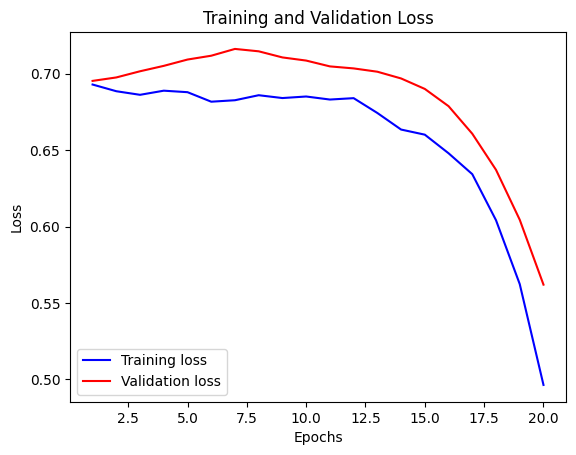

In [ ]:
# Training and Validation Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Epochs
epochs = range(1, len(loss) + 1)

# Plot
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
y_pred = (model.predict(testing_padded) > 0.5).astype("int32")
accuracy = accuracy_score(testing_labels, y_pred)
print("Test Accuracy:", accuracy)

2/2 [==============================] - 0s 9ms/step
Test Accuracy: 0.82


# Strategy 3: Risk Management
Using Risk-Focused Models to Help Inform on Trading Decisions  

#### Measure Stock Tendencies to Reach a “Volatile Behavior” 30 Days after the Inference Point to Determine Risk of Each Stock

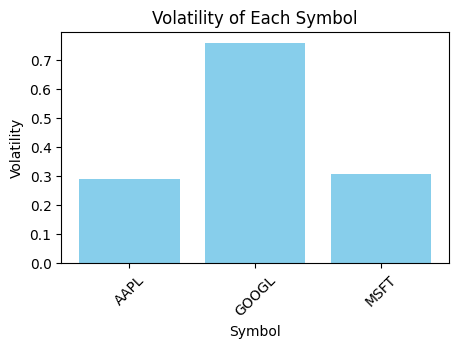


 {'AAPL': 0.008, 'GOOGL': 0.0149, 'MSFT': 0.0104}


In [ ]:
def measure_volatility(data, symbols, start_date, inference_point=30):
    """
    Measure the Volatility of Each Symbol Over a 30-Day Period After the Inference Point
    """
    volatility = {}
    for symbol in symbols:
        symbol_data = data.loc[symbol][start_date:]
        pct_change = symbol_data['close'].pct_change().dropna()
        volatility[symbol] = pct_change.std() * np.sqrt(252)  # Annualize Volatility
    return volatility

def plot_volatility(volatility):
    """
    Plot the Volatility of Each Symbol
    """
    plt.figure(figsize=(5, 3))
    symbols = list(volatility.keys())
    volatilities = list(volatility.values())
    plt.bar(symbols, volatilities, color='skyblue')
    plt.title('Volatility of Each Symbol')
    plt.xlabel('Symbol')
    plt.ylabel('Volatility')
    plt.xticks(rotation=45)
    plt.show()

def measure_risk(data, symbols, start_date, end_date, inference_point=30, confidence_interval=95):
    """
    Measure the Risk of Each Stock Based on Volatility Over a 30-Day Period After the Inference Point
    """
    risk = {}
    for symbol in symbols:
        symbol_data = data.loc[symbol][start_date:end_date]
        volatility = symbol_data['close'].pct_change().rolling(window=inference_point).std().iloc[-1]
        risk[symbol] = volatility.round(4)
    return risk

volatility_data = measure_volatility(data, symbols, start_date)
plot_volatility(volatility_data)

risk_data = measure_risk(data, symbols, start_date, end_date)
print("\n", risk_data)

#### Value at Risk for Each Symbol

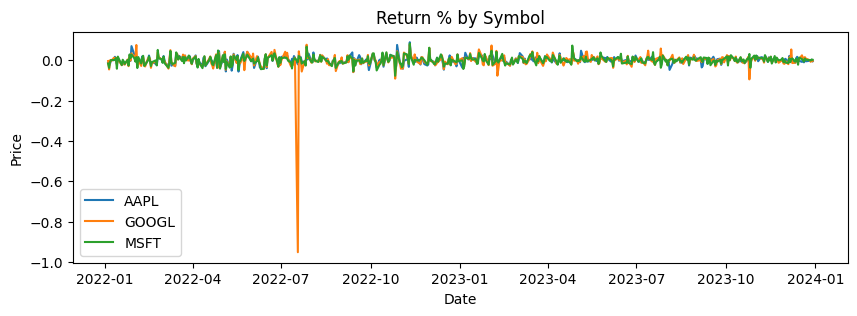


AAPL  Value at Risk:  -3.0060606066302307
GOOGL  Value at Risk:  -3.3516484740080483
MSFT  Value at Risk:  -3.0911953912300545

 The best symbol is: AAPL with 95% confidence interval, the worst loss is -3.01% 



'AAPL'

In [ ]:
def value_at_risk(data, symbols, start_date, end_date, confidence_interval = 95):

  # Initial Dataset
  for symbol in symbols:
    symbol_data = data.loc[symbol]

    # Convert Index to Datetime if Necessary
    if not isinstance(symbol_data.index, pd.DatetimeIndex):
        symbol_data.index = pd.to_datetime(symbol_data.index)

  # Get Dataset With Each Symbol as One Column
  new_data = data.loc[symbols[0]][["close"]]
  new_data = new_data.rename(columns = {"close":symbols[0]})
  for symbol in symbols[1:]:
    new_data[symbol] = data.loc[symbol][["close"]].values

  # Filter Dates
  new_data = new_data[start_date:end_date]

  # DataFrame for Returns of Each Day
  returns = new_data.pct_change().dropna()

  # Plot Returns
  plt.figure(figsize=(10,3))
  for symbol in symbols:
    plt.plot(returns.index, returns[symbol], label=symbol)
  plt.title('Return % by Symbol')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.show()

  print()

  # Get Value at Risk for Each Symbol and Select the Best One
  confidence_interval_inv = 100 - confidence_interval
  best_symbol = ""
  best_return_perc = -100

  for symbol in symbols:
    return_current = np.percentile(returns[symbol], confidence_interval_inv) * 100

    print(symbol, " Value at Risk: ", return_current)

    if return_current > best_return_perc:
      best_return_perc = return_current
      best_symbol = symbol

  # Print Result of Best Symbol
  print("\n The best symbol is: {} with {}% confidence interval, the worst loss is {:.2f}% \n".format(best_symbol, confidence_interval, best_return_perc))

  return best_symbol

value_at_risk(data, symbols, start_date, end_date, 95)

# **Chosen Model and Stock**
Choosing a Model and Stock Based on the Performance of Each of the Strategies and Stocks

Epoch 1/100
34/34 [==============================] - 4s 28ms/step - loss: 24047.0449 - val_loss: 33719.1016
Epoch 2/100
34/34 [==============================] - 0s 9ms/step - loss: 23953.4980 - val_loss: 33570.6523
Epoch 3/100
34/34 [==============================] - 0s 9ms/step - loss: 23828.4219 - val_loss: 33411.0156
Epoch 4/100
34/34 [==============================] - 0s 8ms/step - loss: 23728.2715 - val_loss: 33229.0039
Epoch 5/100
34/34 [==============================] - 0s 5ms/step - loss: 23587.5137 - val_loss: 32999.1602
Epoch 6/100
34/34 [==============================] - 0s 5ms/step - loss: 23334.9531 - val_loss: 32589.9590
Epoch 7/100
34/34 [==============================] - 0s 5ms/step - loss: 22946.0488 - val_loss: 31657.7207
Epoch 8/100
34/34 [==============================] - 0s 5ms/step - loss: 21938.1660 - val_loss: 29190.2832
Epoch 9/100
34/34 [==============================] - 0s 5ms/step - loss: 19516.9668 - val_loss: 24309.1992
Epoch 10/100
34/34 [================

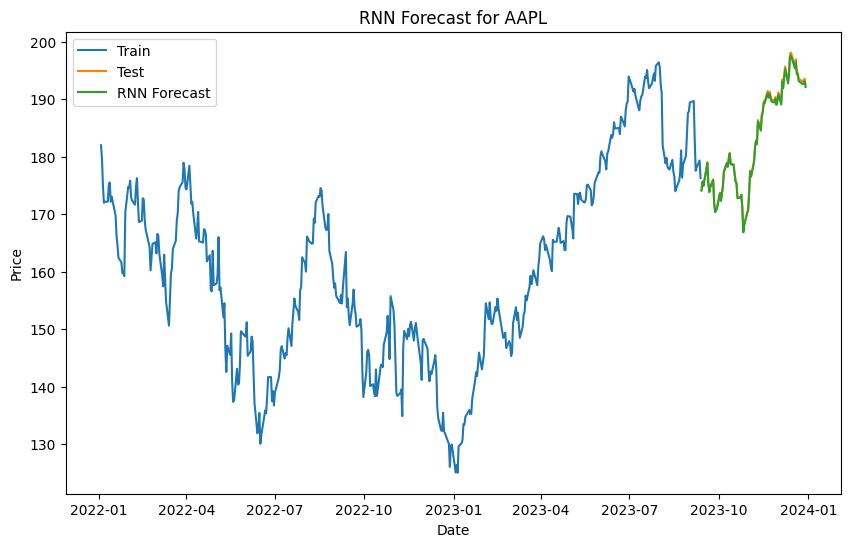



RNN Forecasting - Train RMSE for AAPL: 0.14
RNN Forecasting - Test RMSE for AAPL: 0.29 



In [14]:
rnn_signals = {}

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Chosen Stock
symbol = 'AAPL'
symbol_data = data.loc[symbol]

# Prepare Data for LSTM
X = symbol_data['close'].values.reshape(-1, 1)
y = symbol_data['close'].values

# Split Data Into Train and Test Datasets
train_size = int(len(X) * 0.85)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size,:], X[train_size:,:]
y_train, y_test = y[0:train_size], y[train_size:]


# Reshape Data for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Define RNN Model
model_rnn = Sequential([
    LSTM(units=50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, activation='relu'),
    Dropout(0.2),
    Dense(units=1)
])

optimizer = Adam(learning_rate=0.0001)

# Compile Model
model_rnn.compile(optimizer=optimizer, loss='mean_squared_error')

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               min_delta=1,
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)

# Fit Model
history = model_rnn.fit(X_train_lstm, y_train, epochs=100, batch_size = 10, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Predictions
train_predict_rnn = model_rnn.predict(X_train_lstm)
test_predict_rnn = model_rnn.predict(X_test_lstm)

# Create Signals: Buy When Forecasted Price Increases, Sell When Forecasted Price Decreases
signal_rnn = np.where(test_predict_rnn.squeeze() > X_test_lstm.squeeze(), 1, -1)
print("\n", signal_rnn, "\n")

# Store Forecasted Values and Signal
rnn_signals[symbol] = {'forecast': test_predict_rnn, 'signal': signal_rnn, 'index': symbol_data[train_size:].index}

# Plot Forecast
plt.figure(figsize=(10,6))
plt.plot(symbol_data[:train_size].index, X_train, label='Train')
plt.plot(symbol_data[train_size:].index, X_test, label='Test')
plt.plot(symbol_data[train_size:].index, test_predict_rnn, label='RNN Forecast')
plt.title('RNN Forecast for {}'.format(symbol))
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# RMSE for RNN
rmse_rnn_train = sqrt(mean_squared_error(y_train, train_predict_rnn))
rmse_rnn_test = sqrt(mean_squared_error(y_test, test_predict_rnn))
print("\n")
print('RNN Forecasting - Train RMSE for {}: {:.2f}'.format(symbol, rmse_rnn_train))
print('RNN Forecasting - Test RMSE for {}: {:.2f}'.format(symbol, rmse_rnn_test), "\n")

RNN selected as the chosen model due its ability to predict better than ARIMA, as shown in the results of Strategy 1. Additionally, Strategy 2's use sentiment analysis is based on a small amount of articles. As for Strategy 3, the use of risk models may be too conservative to use for stock trading; however, its results will still inform the chosen RNN model in that the risk models indicate that AAPL is the lowest risk stock to invest in, which is what the chosen model will be utilizing.

#### Save Model

In [20]:
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
model_rnn.save('/content/drive/MyDrive/Colab Datasets/RealTime/chosen_model_rnn_aapl.keras')

# **Backtesting**
Testing Chosen Model on Chosen Stock via A Form of Backtesting that Focuses on Stock's Portfolio

In [22]:
# Data for Backtesting

request = StockBarsRequest(
                        symbol_or_symbols=["AAPL", "GOOGL", "MSFT"],
                        timeframe=TimeFrame.Day,
                        start="2023-09-13 00:00:00",
                        end="2023-12-29 00:00:00"
                 )

backtesting_bars = client.get_stock_bars(request)
backtesting_bars_df = backtesting_bars.df
backtesting_df = pd.DataFrame(backtesting_bars_df)
backtesting_df.head()

open     high     low   close  \
symbol timestamp                                                    
AAPL   2023-09-13 04:00:00+00:00  176.51  177.300  173.98  174.21   
       2023-09-14 04:00:00+00:00  174.00  176.100  173.58  175.74   
       2023-09-15 04:00:00+00:00  176.48  176.495  173.82  175.01   
       2023-09-18 04:00:00+00:00  176.48  179.380  176.17  177.97   
       2023-09-19 04:00:00+00:00  177.52  179.630  177.13  179.07   

                                       volume  trade_count        vwap  
symbol timestamp                                                        
AAPL   2023-09-13 04:00:00+00:00   84277767.0     835414.0  175.035093  
       2023-09-14 04:00:00+00:00   60898149.0     641142.0  175.370606  
       2023-09-15 04:00:00+00:00  109259462.0     729795.0  175.084343  
       2023-09-18 04:00:00+00:00   67272034.0     731499.0  177.891568  
       2023-09-19 04:00:00+00:00   51831661.0     524532.0  178.429407

In [23]:
def generate_signals(forecasted_prices):
    signals = [0]

    for i in range(1, len(forecasted_prices)):
        if forecasted_prices[i] > forecasted_prices[i - 1]:
            signals.append(1)
        elif forecasted_prices[i] < forecasted_prices[i - 1]:
            signals.append(-1)
        else:
            signals.append(0)

    return signals

signals = generate_signals(test_predict_rnn.squeeze())

signals_rnn = np.array(signals)

signals_rnn

array([ 0,  1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  1,
        1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1,
        1,  1,  1, -1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1,  1, -1,  1,
       -1, -1,  1, -1,  1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1, -1, -1,
        1, -1, -1, -1, -1,  1,  1, -1])

Portfolio for AAPL
                             AAPL  holdings      cash     total   returns
timestamp                                                                
2023-09-13 04:00:00+00:00     0.0       0.0  100000.0  100000.0       NaN
2023-09-14 04:00:00+00:00  1757.4    1757.4   98242.6  100000.0  0.000000
2023-09-15 04:00:00+00:00 -1750.1   -1750.1  101742.8   99992.7 -0.000073
2023-09-18 04:00:00+00:00  1779.7    1779.7   98183.4   99963.1 -0.000296
2023-09-19 04:00:00+00:00  1790.7    1790.7   98183.4   99974.1  0.000110
...                           ...       ...       ...       ...       ...
2023-12-22 05:00:00+00:00 -1936.0   -1936.0  101850.8   99914.8  0.000108
2023-12-26 05:00:00+00:00 -1930.5   -1930.5  101850.8   99920.3  0.000055
2023-12-27 05:00:00+00:00  1931.5    1931.5   97987.8   99919.3 -0.000010
2023-12-28 05:00:00+00:00  1935.8    1935.8   97987.8   99923.6  0.000043
2023-12-29 05:00:00+00:00     NaN       0.0   97987.8   97987.8 -0.019373

[76 rows x 5 colum

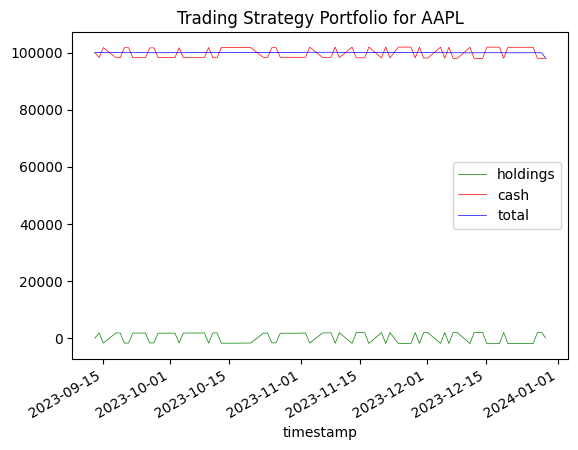



Portfolio for AAPL:
                             AAPL  holdings      cash     total   returns
timestamp                                                                
2023-09-13 04:00:00+00:00     0.0       0.0  100000.0  100000.0       NaN
2023-09-14 04:00:00+00:00  1757.4    1757.4   98242.6  100000.0  0.000000
2023-09-15 04:00:00+00:00 -1750.1   -1750.1  101742.8   99992.7 -0.000073
2023-09-18 04:00:00+00:00  1779.7    1779.7   98183.4   99963.1 -0.000296
2023-09-19 04:00:00+00:00  1790.7    1790.7   98183.4   99974.1  0.000110
...                           ...       ...       ...       ...       ...
2023-12-22 05:00:00+00:00 -1936.0   -1936.0  101850.8   99914.8  0.000108
2023-12-26 05:00:00+00:00 -1930.5   -1930.5  101850.8   99920.3  0.000055
2023-12-27 05:00:00+00:00  1931.5    1931.5   97987.8   99919.3 -0.000010
2023-12-28 05:00:00+00:00  1935.8    1935.8   97987.8   99923.6  0.000043
2023-12-29 05:00:00+00:00     NaN       0.0   97987.8   97987.8 -0.019373

[76 rows x 5 co

In [24]:
all_portfolios = {}

# Create DataFrame to Store Positions for RNN
positions_rnn = pd.DataFrame(index=rnn_signals[symbol]['index']).fillna(0.0)

# Get the test timestamps for RNN forecast
test_timestamps = symbol_data.index[-len(X_test_lstm):]

# Create a Series for the RNN forecast with timestamps as index
rnn_forecast_series = pd.Series(test_predict_rnn.squeeze(), index=test_timestamps)

# Assign RNN forecast Series to rnn_signals dictionary
rnn_signals[symbol]['forecast'] = rnn_forecast_series

# Buy/Sell 10 Shares When Signal is 1/-1 for RNN
positions_rnn[symbol] = 10 * signals_rnn

positions = positions_rnn

# Calculate Portfolio Based on Positions and Price
portfolio = positions.multiply(backtesting_df.loc[symbol]['close'], axis=0)

# Add 'holdings' to Portfolio
portfolio['holdings'] = positions.multiply(backtesting_df.loc[symbol]['close'], axis=0).sum(axis=1)

# Calculate Cash
pos_diff = positions.diff()
portfolio['cash'] = initial_capital - (pos_diff.multiply(backtesting_df.loc[symbol]['close'], axis=0)).sum(axis=1).cumsum()

# Calculate Total Portfolio Value
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Calculate Returns
portfolio['returns'] = portfolio['total'].pct_change()

# Store Portfolio in the Dictionary
all_portfolios[symbol] = portfolio

# Print Portfolio
print("Portfolio for", symbol)
print(portfolio, "\n")

# Plot Portfolio
portfolio['holdings'].plot(color='g', lw=0.5)
portfolio['cash'].plot(color='r', lw=0.5)
portfolio['total'].plot(color='b', lw=0.5)
plt.title("Trading Strategy Portfolio for {}".format(symbol))
plt.legend()
plt.show()
print("\n")

# Access Individual Portfolios
print("Portfolio for AAPL:")
print(all_portfolios.get('AAPL'))

# **References**


1. Chowdhury, R. (2022, February 7). *Sentiments Analysis of Financial News with News API and Transformers*. Alpaca . https://alpaca.markets/learn/sentiment-analysis-with-news-api-and-transformers/
2. Davda, J. (2021, February 28). *Alpaca Trading API Guide – A Step-by-step Guide*. AlgoTrading101 Blog. https://algotrading101.com/learn/alpaca-trading-api-guide/
3. Part Time Larry. (2019, September 28). *Paper trading with the alpaca API*. YouTube. https://www.youtube.com/watch?v=GsGeLHTOGAg    